In [1]:
import pandas as pd # to work on data frames and can handle any outlier or noise records in datasets
import numpy as np # to get algebratic opertaion on data
import matplotlib.pyplot as plt # to visualize data and cleaning ( i do it to show outputs of my cleaning (my point of veiw)) 
import seaborn as sns

import os
import pickle
import random
import re # this library work on regular expressions for pattern matching and string manipulation i search alot on it i understand this only
import string # this library has ASCII letters, digits, punctuation, and whitespace i use it to get (punctuation) to remove it from data
import nltk # library we use to preprocess on text data to make it clean and in standerd form to use it in NLP
from nltk.corpus import stopwords # this module we use to remove stopwords
from nltk.tokenize import word_tokenize # this module we use it to tokanise text into words
from nltk.stem import WordNetLemmatizer # this lemmatizedr get base of each word to make words in his base ( if verb , noun , adverb or adgectives)

from collections import Counter

from sklearn.utils import resample # this module i use to oversample my data to get representitive data to represent toxic and nun-toxic equally
from sklearn.model_selection import train_test_split # to split dataset into training and testing and validation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score # to calculate accuracy and all of f1 score and other matrices

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset,Dataset


c:\Users\bassel\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import torch

# Set the device (either CUDA or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    # Get the index of the current GPU
    device_index = torch.cuda.current_device()
    
    # Limit the GPU memory usage to 70% of the available memory
    torch.cuda.set_per_process_memory_fraction(0.7, device_index)

# Now, your model and tensors will use only 70% of the available GPU memory.


# Text Classification

In [4]:
new_data = pd.read_csv(r"D:\FCDS\semster 7\NLP\Assginments\Assginment 2\cleaned_reviews.csv")

In [5]:
# Apply tokenization to the 'cleaned_review' column
new_data['cleaned_review'] = new_data['cleaned_review'].apply(word_tokenize)
new_data


,cleaned_review,encoded_sentiment
0,"[one, reviewer, mention, watch, oz, episode, y...",1
1,"[wonderful, little, production, br, br, film, ...",1
2,"[think, wonderful, way, spend, time, hot, summ...",1
3,"[basically, there, family, little, boy, jake, ...",0
4,"[petter, matteis, love, time, money, visually,...",1
...,...,...
49577,"[think, movie, right, good, job, wasnt, creati...",1
49578,"[bad, plot, bad, dialogue, bad, act, idiotic, ...",0
49579,"[catholic, teach, parochial, elementary, schoo...",0
49580,"[im, go, disagree, previous, comment, side, ma...",0


In [6]:
# Define maximum number of words and sequence length
max_words = 10000
max_sequence_length = 100

# Tokenize and convert text to sequences
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(new_data['cleaned_review'].apply(lambda x: ' '.join(x)))
sequences = tokenizer.texts_to_sequences(new_data['cleaned_review'].apply(lambda x: ' '.join(x)))

# Pad sequences to ensure uniform length
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# Convert to tensors
X = torch.tensor(padded_sequences, dtype=torch.long)
y = torch.tensor(new_data['encoded_sentiment'].values, dtype=torch.float)  # Replace with your target column

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# GloVe (Global Vectors for Word Representation)
Pros:
GloVe embeddings are pre-trained on large corpora, making them suitable for general text understanding.

- GloVe: Recommended if you have a large, general corpus with standard vocabulary.
- FastText: Recommended if you have a dataset with many rare, misspelled, or domain-specific words.
- Word2Vec: A good alternative to GloVe, especially if you're using the Google News pre-trained model.

In [7]:
def load_glove_model(file_path):
    print("Loading GloVe model...")
    glove_model = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_model[word] = vector
    print(f"Loaded {len(glove_model)} word vectors.")
    return glove_model

# Example: Load the 100-dimensional GloVe vectors
glove_file_path = r"D:\FCDS\semster 7\NLP\Assginments\Assginment 2\glove.6B.300d.txt\glove.6B.300d.txt"
glove_model = load_glove_model(glove_file_path)


Loading GloVe model...
Loaded 400000 word vectors.


In [8]:
# Create an embedding matrix
embedding_dim = 300  
embedding_matrix = np.zeros((max_words, embedding_dim))

# Populate the embedding matrix with the GloVe vectors
for word, index in tokenizer.word_index.items():
    if index >= max_words:
        continue
    embedding_vector = glove_model.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


# Classifier

In [9]:
class RNNClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, dropout_rate):
        super(RNNClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        
        # Randomly initialized embedding layer
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float), freeze=False
        )
        
        # RNN layer
        self.rnn = nn.RNN(
            input_size=embedding_dim, hidden_size=hidden_dim, num_layers=2, batch_first=True
        )
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        # Get embeddings for input x
        embedded = self.embedding(x)
        
        # Pass through RNN
        _, hidden = self.rnn(embedded)
        
        # Use the last hidden state (final time step)
        hidden = hidden[-1]  # Last layer's hidden state
        
        # Pass through fully connected layer with dropout
        out = self.fc(self.dropout(hidden))
        
        return out

In [10]:
# Instantiate the RNN model
hidden_dim = 128  # RNN hidden state dimension
output_dim = 1  # Binary classification
dropout_rate = 0.2

model = RNNClassifier(embedding_matrix, hidden_dim, output_dim, dropout_rate)
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [11]:

# Create DataLoaders
batch_size = 32
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [12]:
epochs = 30

In [13]:
def Train(model):
    History = {}
    Accuracy = []
    Losses = []
    model = model.to(device)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0
        
        for X_batch, y_batch in tqdm(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            predictions = model(X_batch)  # Model output
            
            # Ensure predictions and y_batch have the same shape
            predictions = predictions.view(-1, 1)  # Ensure predictions have shape (batch_size, 1)
            
            if y_batch.dim() == 1:
                y_batch = y_batch.unsqueeze(1)  # Make sure y_batch has shape (batch_size, 1)
            
            # Calculate loss
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            # Calculate accuracy
            predicted_labels = (predictions > 0.5).float()  # For binary classification (0 or 1)
            correct_predictions += (predicted_labels == y_batch).sum().item()
            total_predictions += y_batch.size(0)
        
        accuracy = correct_predictions / total_predictions * 100
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")
        Losses.append((total_loss/len(train_loader)))
        Accuracy.append(accuracy)
    
    History['Accuracy'] = Accuracy
    History['Loss'] = Losses
    return model ,History


In [14]:
def Eval(model ,history):
    model.eval()
    
    all_preds = []
    all_labels = []
    
    # Evaluate the model
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Get predictions from the model
            predictions = model(X_batch).squeeze()
            
            # Convert probabilities to binary predictions
            predicted_labels = (torch.sigmoid(predictions) > 0.5).float()
            
            # Store predictions and true labels
            all_preds.extend(predicted_labels.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    
    try:
        roc_auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        roc_auc = None

    # Store metrics in a DataFrame
    metrics_df = pd.DataFrame({
        "Metric": ["Accuracy", "Precision", "Recall", "F1-Score", "ROC AUC"],
        "Value": [accuracy, precision, recall, f1, roc_auc if roc_auc is not None else "N/A"]
    })
    
    print(metrics_df)
    
    # Plot Accuracy and Loss from History
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['Accuracy'], label='Train Accuracy', marker='o')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['Loss'], label='Train Loss', marker='o')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
    return metrics_df

In [15]:
model ,history = Train(model)

  0%|          | 0/1240 [00:00<?, ?it/s]

Epoch 1/30, Loss: 0.6799, Accuracy: 53.38%


  0%|          | 0/1240 [00:00<?, ?it/s]

Epoch 2/30, Loss: 0.6764, Accuracy: 52.91%


  0%|          | 0/1240 [00:00<?, ?it/s]

Epoch 3/30, Loss: 0.6796, Accuracy: 53.53%


  0%|          | 0/1240 [00:00<?, ?it/s]

Epoch 4/30, Loss: 0.6054, Accuracy: 64.72%


  0%|          | 0/1240 [00:00<?, ?it/s]

Epoch 5/30, Loss: 0.6081, Accuracy: 64.21%


  0%|          | 0/1240 [00:00<?, ?it/s]

Epoch 6/30, Loss: 0.6475, Accuracy: 57.90%


  0%|          | 0/1240 [00:00<?, ?it/s]

Epoch 7/30, Loss: 0.6227, Accuracy: 61.20%


  0%|          | 0/1240 [00:00<?, ?it/s]

Epoch 8/30, Loss: 0.6405, Accuracy: 58.00%


  0%|          | 0/1240 [00:00<?, ?it/s]

Epoch 9/30, Loss: 0.6086, Accuracy: 63.18%


  0%|          | 0/1240 [00:00<?, ?it/s]

Epoch 10/30, Loss: 0.6009, Accuracy: 64.69%


  0%|          | 0/1240 [00:00<?, ?it/s]

Epoch 11/30, Loss: 0.5298, Accuracy: 74.61%


  0%|          | 0/1240 [00:00<?, ?it/s]

Epoch 12/30, Loss: 0.5925, Accuracy: 66.40%


  0%|          | 0/1240 [00:00<?, ?it/s]

Epoch 13/30, Loss: 0.6455, Accuracy: 57.74%


  0%|          | 0/1240 [00:00<?, ?it/s]

Epoch 14/30, Loss: 0.6096, Accuracy: 63.10%


  0%|          | 0/1240 [00:00<?, ?it/s]

Epoch 15/30, Loss: 0.6025, Accuracy: 63.81%


  0%|          | 0/1240 [00:00<?, ?it/s]

Epoch 16/30, Loss: 0.5472, Accuracy: 70.44%


  0%|          | 0/1240 [00:00<?, ?it/s]

Epoch 17/30, Loss: 0.5573, Accuracy: 70.10%


  0%|          | 0/1240 [00:00<?, ?it/s]

Epoch 18/30, Loss: 0.5280, Accuracy: 74.68%


  0%|          | 0/1240 [00:00<?, ?it/s]

Epoch 19/30, Loss: 0.5251, Accuracy: 73.38%


  0%|          | 0/1240 [00:00<?, ?it/s]

Epoch 20/30, Loss: 0.4673, Accuracy: 80.00%


  0%|          | 0/1240 [00:00<?, ?it/s]

Epoch 21/30, Loss: 0.4809, Accuracy: 77.85%


  0%|          | 0/1240 [00:00<?, ?it/s]

Epoch 22/30, Loss: 0.5638, Accuracy: 67.89%


  0%|          | 0/1240 [00:00<?, ?it/s]

Epoch 23/30, Loss: 0.4873, Accuracy: 77.39%


  0%|          | 0/1240 [00:00<?, ?it/s]

Epoch 24/30, Loss: 0.5187, Accuracy: 73.96%


  0%|          | 0/1240 [00:00<?, ?it/s]

Epoch 25/30, Loss: 0.5171, Accuracy: 72.25%


  0%|          | 0/1240 [00:00<?, ?it/s]

Epoch 26/30, Loss: 0.5085, Accuracy: 75.04%


  0%|          | 0/1240 [00:00<?, ?it/s]

Epoch 27/30, Loss: 0.4721, Accuracy: 78.79%


  0%|          | 0/1240 [00:00<?, ?it/s]

Epoch 28/30, Loss: 0.4807, Accuracy: 77.98%


  0%|          | 0/1240 [00:00<?, ?it/s]

Epoch 29/30, Loss: 0.5086, Accuracy: 75.34%


  0%|          | 0/1240 [00:00<?, ?it/s]

Epoch 30/30, Loss: 0.6325, Accuracy: 60.28%


      Metric     Value
0   Accuracy  0.635474
1  Precision  0.629292
2     Recall  0.666332
3   F1-Score  0.647283
4    ROC AUC  0.635353


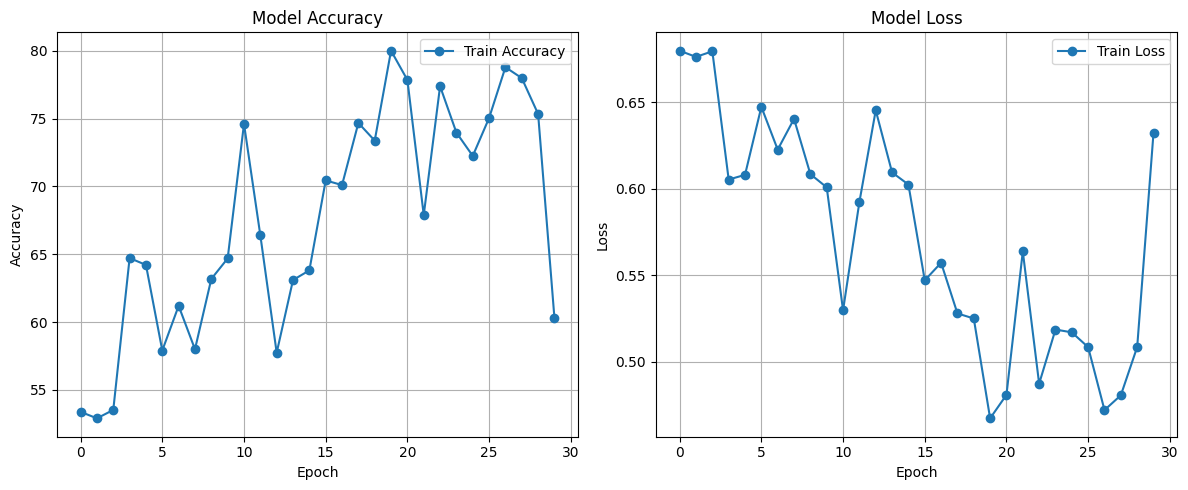

In [16]:
rnn_metrics = Eval(model ,history)
rnn_metrics['Model'] = 'RNN'

In [17]:
import torch

# Empty the cache to free up unused memory
torch.cuda.empty_cache()

# Force garbage collection to free unused memory
import gc
gc.collect()

7036

# Language Model

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [34]:
print(torch.cuda.memory_summary(device=device))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   1703 MiB |   1703 MiB |   5718 GiB |   5717 GiB |
|       from large pool |   1702 MiB |   1702 MiB |   5677 GiB |   5675 GiB |
|       from small pool |      1 MiB |      3 MiB |     41 GiB |     41 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   1703 MiB |   1703 MiB |   5718 GiB |   5717 GiB |
|       from large pool |   1702 MiB |   1702 MiB |   5677 GiB |

In [2]:
# Setup paths
DATA_PATH = r"G:\mazen FCDS\FCDS\NLP\Assginment 2\language model"
LINES_FILE = os.path.join(DATA_PATH, "movie_lines.txt")
CONVERSATIONS_FILE = os.path.join(DATA_PATH, "movie_conversations.txt")

# Function to load movie lines
def load_lines(file_path):
    lines = {}
    with open(file_path, "r", encoding="utf-8", errors="ignore") as file:
        for line in file:
            parts = line.strip().split(" +++$+++ ")
            if len(parts) >= 5:
                line_id, text = parts[0], parts[4]
                lines[line_id] = text
    return lines

# Function to load movie conversations
def load_conversations(file_path, lines):
    conversations = []
    with open(file_path, "r", encoding="utf-8", errors="ignore") as file:
        for line in file:
            parts = line.strip().split(" +++$+++ ")
            if len(parts) >= 4:
                utterance_ids = eval(parts[3])  # Convert string to list
                conversations.append([lines[line_id] for line_id in utterance_ids if line_id in lines])
    return conversations

# Clean text function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9?.!]+", " ", text)  # Remove special characters
    text = re.sub(r"([?.!])", r" \1 ", text)       # Add space around punctuation
    text = re.sub(r"\s+", " ", text).strip()       # Remove extra spaces
    return text

# Load conversations
lines = load_lines(LINES_FILE)
conversations = load_conversations(CONVERSATIONS_FILE, lines)

# Clean each utterance
cleaned_conversations = [[clean_text(utterance) for utterance in conv] for conv in conversations]

# Download NLTK tokenization resources
nltk.download('punkt')

# Tokenize conversations
def tokenize(conversations):
    return [[word_tokenize(utterance) for utterance in conv] for conv in conversations]

# Tokenize cleaned conversations
tokenized_conversations = tokenize(cleaned_conversations)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bassel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Special tokens
PAD_TOKEN = "<PAD>"
SOS_TOKEN = "<SOS>"
EOS_TOKEN = "<EOS>"
UNK_TOKEN = "<UNK>"

# Build vocabulary function
def build_vocab(tokenized_conversations):
    counter = Counter()
    for conv in tokenized_conversations:
        for utterance in conv:
            counter.update(utterance)
    
    # Sort by frequency
    sorted_vocab = [word for word, _ in counter.most_common()]
    
    # Add special tokens
    vocab = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN] + sorted_vocab
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2word = {idx: word for word, idx in word2idx.items()}
    return word2idx, idx2word

# Build vocabulary
word2idx, idx2word = build_vocab(tokenized_conversations)

# Convert sentences to sequences
def sentences_to_sequences(conversations, word2idx):
    sequences = []
    for conv in conversations:
        for utterance in conv:
            seq = [word2idx.get(word, word2idx[UNK_TOKEN]) for word in utterance]
            sequences.append([word2idx[SOS_TOKEN]] + seq + [word2idx[EOS_TOKEN]])
    return sequences

# Pad sequences
def pad_sequences(sequences, pad_token, vocab_size, max_length=None):
    # Find the maximum length of sequences if not provided
    if max_length is None:
        max_length = max(len(seq) for seq in sequences)

    # Pad sequences
    padded = []
    for seq in sequences:
        seq = [min(i, vocab_size - 1) for i in seq[:max_length]] + [pad_token] * max(0, max_length - len(seq))
        padded.append(seq)

    return padded, max_length

sequences = sentences_to_sequences(tokenized_conversations, word2idx)
padded_sequences, max_length = pad_sequences(sequences, word2idx[PAD_TOKEN], len(word2idx))

# Create input-output pairs
def create_input_output_pairs(padded_sequences):
    inputs = [seq[:-1] for seq in padded_sequences]
    outputs = [seq[1:] for seq in padded_sequences]
    return inputs, outputs

inputs, outputs = create_input_output_pairs(padded_sequences)

# Define a custom collate function
def collate_fn(batch):
    inputs = [torch.tensor(item["input"], dtype=torch.long) for item in batch]
    outputs = [torch.tensor(item["output"], dtype=torch.long) for item in batch]
    
    # Pad sequences using the modified pad_sequences function
    padded_inputs, max_length = pad_sequences([seq.tolist() for seq in inputs], word2idx["<PAD>"], len(word2idx))
    padded_outputs, _ = pad_sequences([seq.tolist() for seq in outputs], word2idx["<PAD>"], len(word2idx), max_length)
    
    # Convert back to tensors
    inputs_padded = torch.tensor(padded_inputs, dtype=torch.long)
    outputs_padded = torch.tensor(padded_outputs, dtype=torch.long)
    
    return {"input": inputs_padded, "output": outputs_padded}

# Define a Dataset class
class MovieDialogsDataset(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, index):
        return {"input": self.inputs[index], "output": self.outputs[index]}

# Create dataset and dataloaders
dataset = MovieDialogsDataset(inputs, outputs)
batch_size = 2
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [4]:
# Define the RNN model
class RNNModel(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.rnn = torch.nn.RNN(embedding_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        output = self.fc(output)
        return output

# Initialize model, optimizer, and loss function
vocab_size = len(word2idx)
embedding_dim = 300
hidden_dim = 512
output_dim = vocab_size
model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [5]:
# Training function
def train(model, train_loader, epochs, optimizer, criterion, device):
    History = {'Accuracy': [], 'Loss': []}
    model = model.to(device)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_tokens = 0
        correct_predictions = 0
        
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            X_batch = batch["input"].to(device)
            y_batch = batch["output"].to(device)
            optimizer.zero_grad()
            predictions = model(X_batch)
            predictions = predictions.view(-1, vocab_size)
            y_batch = y_batch.view(-1)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_tokens += (y_batch != word2idx["<PAD>"]).sum().item()
            predicted_labels = predictions.argmax(dim=1)
            correct_predictions += (predicted_labels == y_batch).sum().item()
        
        accuracy = correct_predictions / total_tokens * 100
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")
        History['Loss'].append(total_loss / len(train_loader))
        History['Accuracy'].append(accuracy)
    
    return model, History

# Evaluate function
def evaluate(model, history, test_loader, criterion, device):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    total_tokens = 0
    
    with torch.no_grad():
        for batch in test_loader:
            X_batch = batch["input"].to(device)
            y_batch = batch["output"].to(device)
            predictions = model(X_batch).view(-1, vocab_size)
            y_batch = y_batch.view(-1)
            total_loss += criterion(predictions, y_batch).item()
            total_tokens += (y_batch != word2idx["<PAD>"]).sum().item()
            predicted_labels = predictions.argmax(dim=1)
            all_preds.extend(predicted_labels.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    print(f"Test Loss: {total_loss / len(test_loader):.4f}")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%")
    history['Loss'].append(total_loss / len(test_loader))
    history['Accuracy'].append(accuracy * 100)
    
    return history


In [6]:
# Training
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, train_history = train(model, train_loader, epochs, optimizer, criterion, device)

Epoch 1/10:   0%|          | 158/152223 [04:27<71:33:09,  1.69s/it]


KeyboardInterrupt: 

In [10]:
# Evaluation
test_history = evaluate(model, train_history, test_loader, criterion, device)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(test_history['Accuracy'], label='Accuracy')
plt.plot(test_history['Loss'], label='Loss')
plt.legend()
plt.title('Training History')
plt.show()

NameError: name 'train_history' is not defined